## Multifidelity main notebook
This notebook optimizes on the MSE metric and optimizes given experimental beam size measurements

2024-08-28

F. Cropp

### User Input

In [1]:


filepath='/pscratch/sd/c/rhwang/Training_Data_2024_09_26/' # Where to store the data (symbolic link will be made to this directory)

### Import Statements


In [2]:
import xopt
import impact
from impact.autophase import autophase_and_scale
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.numerical_optimizer import GridOptimizer
import concurrent.futures
import torch
import math
from gpytorch.kernels import PeriodicKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
import h5py
import PIL
import copy
import scipy

import os
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pandas as pd
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pmd_beamphysics
from pytao import Tao
from os import path,environ

from OpenPMD_to_Bmad.Update_h5_file import *
from pathlib import Path
import time

/Users/rhwang/miniforge3/envs/Multifidelity/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Add Bmad path

In [3]:
os.environ['FACET2_LATTICE']=os.path.expanduser(os.getcwd()+'/facet2-lattice')


### Load functions for image analysis and multifidelity

In [4]:
%run -i Helper_Functions.py

### Make symbolic link

In [5]:
cwd = os.getcwd()
try:
    os.mkdir(filepath)
except: pass
os.system('ln -s '+filepath + ' ' + cwd)

ln: /Users/rhwang/Documents/SLAC/facetii-parameter-scans/Training_Data_2024_09_26: File exists


256

### Specify settings

In [6]:
# settings=relevant_df.rename(columns={'BPMS:IN10:221:TMIT1H':'distgen:total_charge:value'})

FILEPATH=filepath #Archive location

try:
    os.makedirs(FILEPATH)
except:pass

SETTINGS0 = {
    'numprocs':1,
    'header:Nx':int(4),
    'header:Ny':int(4),  
    'header:Nz':int(4), 
    'header:Flagdiag':int(3),
    'distgen:n_particle':int(2e2),
    'GUNF:theta0_deg':26.8-90.5,
    'GUNF:rf_field_scale': 123/2.44885*1e6, #114.55/2.44885*1e6,
    'SOL10111:solenoid_field_scale':-0.2,
    'distgen:t_dist:sigma_t:value':1.21,
    'distgen:total_charge:value':1000,
    'SQ10122:b1_gradient':0,
    'CQ10121:b1_gradient':0,
    'PR10241:sample_frequency':1,
    'workdir':filepath,
    'command': '/global/homes/c/cropp/.conda/envs/xopt/bin/ImpactTexe',    
    'command_mpi': '/global/homes/c/cropp/.conda/envs/xopt/bin/ImpactTexe-mpi',
    # 'mpi_run':'salloc --partition milano --account ad:ard-online -N 1 -n {nproc} /usr/lib64/openmpi/bin/mpirun -n {nproc} {command_mpi}'
    'mpi_run':'/global/homes/c/cropp/.conda/envs/xopt/bin/mpirun --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}'
}



# len(settings)
jan_l0a_median = 35.999986091714916e6
mar_l0a_median = 35.999800215136700e6

jan_l0b_median = 33.179023992153766e6
mar_l0b_median = 34.783428998629326e6

### Calculate the energy gain from the linacs

In [7]:
jan_L0A_E_Gain = (Linac_Calc(jan_l0a_median)) # Note that for L0A, a true RF amplitude of L0A is specified
jan_L0B_E_Gain = (Linac_Calc(jan_l0b_median)) # Note that for L0B, an energy gain is specified.  This function converts these.  

### Define data range

In [8]:
cal_data = {'impact_GUNF:rf_field_scale':[115/2.44885*1e6,125/2.44885*1e6], 'bmad_QE10525':[-5,5]}

#Other possible values include: 'impact_GUNF:theta0_deg':,'impact_distgen:t_dist:sigma_t:value','impact_distgen:start:MTE:value',
#'impact_SOL10111:solenoid_field_scale''impact_SQ10122:b1_gradient','impact_CQ10121:b1_gradient','impact_distgen:total_charge:value','impact_L0AF_scale:rf_field_scale',
#'impact_L0AF_phase:theta0_deg','bmad_L0BF_scale:rf_field_scale','bmad_L0BF_phase:theta0_deg','bmad_QA10361','bmad_QA10371','bmad_QE10425','bmad_QE10441','bmad_QE10511'


### Make evaluation points


In [12]:
N = 25
cutoff_sigma = 3

# For Robin's project: quasi-random Gaussian
points = {}
for key in cal_data.keys():
    mu = np.mean(np.array(cal_data[key]))
    sigma = np.ptp(np.array(cal_data[key]))/(2*cutoff_sigma)
    dist = Gaussian_Dist_Maker(N,mu,sigma,cutoff_sigma,cutoff_sigma)
    points[key] = dist
points = pd.DataFrame(points)

# For training data: pseudorandom uniform
for key in cal_data.keys():
    dist = np.random.uniform(np.min(cal_data[key]),np.max(cal_data[key]),N)
    points[key] = dist
points = pd.DataFrame(points)

### Example plot

(array([5., 2., 2., 4., 0., 2., 4., 2., 0., 4.]),
 array([47050956.88916548, 47443695.84086165, 47836434.79255782,
        48229173.74425399, 48621912.69595017, 49014651.64764634,
        49407390.59934252, 49800129.55103869, 50192868.50273486,
        50585607.45443103, 50978346.40612721]),
 <BarContainer object of 10 artists>)

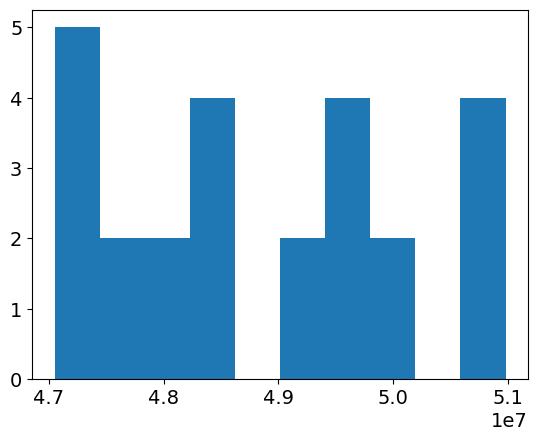

In [13]:
plt.hist(points['impact_GUNF:rf_field_scale'])

## Define Low-Level Xopt Object for Parameter Scans


In [14]:


evaluator1=xopt.evaluator.Evaluator(function=run_impact_bmad, 
                                   function_kwargs={'impact_config':'./Impact_Lattice_Jan_2024/ImpactT.yaml',
                                                    'distgen_input_file': './Impact_Lattice_Jan_2024/distgen.yaml',
                                                    'verbose':False})

evaluator1.executor=concurrent.futures.ProcessPoolExecutor() 
evaluator1.max_workers=250
evaluator1.vectorized=False


## Update settings and run

In [16]:
settings = pd.DataFrame(points)
settings = settings.drop_duplicates()
impact_settings,bmad_settings = split_impact_bmad_settings(settings)
impact_settings = pd.DataFrame(impact_settings)
bmad_settings = pd.DataFrame(bmad_settings)
impact_settings=update_settings(impact_settings,SETTINGS0)
impact_settings['impactT_ID'] = impact_settings.index

combined_settings = combine_impact_bmad_settings(impact_settings,bmad_settings)

# For running on NERSC
filepath=filepath+str(subfolder_number(filepath)+1)+'/'

combined_settings['filepath'] = filepath

results = evaluator1.evaluate_data(combined_settings)

### View result

In [17]:
results

,impact_numprocs,impact_header:Nx,impact_header:Ny,impact_header:Nz,impact_header:Flagdiag,impact_distgen:n_particle,impact_GUNF:theta0_deg,impact_GUNF:rf_field_scale,impact_SOL10111:solenoid_field_scale,impact_distgen:t_dist:sigma_t:value,...,impact_workdir,impact_command,impact_command_mpi,impact_mpi_run,impact_impactT_ID,bmad_QE10525,filepath,xopt_runtime,xopt_error,xopt_error_str
0,1,4,4,4,3,200,-63.7,4.966875e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,0,-1.835685,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.009572,True,"Traceback (most recent call last):\n File ""/U..."
1,1,4,4,4,3,200,-63.7,5.097835e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,1,-2.242647,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.008968,True,"Traceback (most recent call last):\n File ""/U..."
2,1,4,4,4,3,200,-63.7,4.739227e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,2,-3.066045,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.010554,True,"Traceback (most recent call last):\n File ""/U..."
3,1,4,4,4,3,200,-63.7,4.705096e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,3,-4.408788,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.013481,True,"Traceback (most recent call last):\n File ""/U..."
4,1,4,4,4,3,200,-63.7,5.073593e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,4,0.065609,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.005490,True,"Traceback (most recent call last):\n File ""/U..."
5,1,4,4,4,3,200,-63.7,4.847813e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,5,-3.611918,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.009230,True,"Traceback (most recent call last):\n File ""/U..."
6,1,4,4,4,3,200,-63.7,4.933843e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,6,2.259347,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.009667,True,"Traceback (most recent call last):\n File ""/U..."
7,1,4,4,4,3,200,-63.7,4.988112e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,7,-0.914261,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.010217,True,"Traceback (most recent call last):\n File ""/U..."
8,1,4,4,4,3,200,-63.7,4.748821e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,8,-2.426933,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,0.006731,True,"Traceback (most recent call last):\n File ""/U..."
9,1,4,4,4,3,200,-63.7,4.959732e+07,-0.2,1.21,...,/pscratch/sd/c/rhwang/Training_Data_2024_09_26/,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/Imp...,/global/homes/c/cropp/.conda/envs/xopt/bin/mpi...,9,-4.452335